In [63]:
# import modules
%matplotlib inline
from IPython.display import clear_output

import os
import pylab
import random
import numpy as np
import pandas as pd
import cPickle as pkl
import theano.tensor as T

from skimage import transform
from scipy.misc import imread, imresize
from skimage.exposure import adjust_gamma
from sklearn.preprocessing import LabelEncoder

from lasagne import layers, updates, nonlinearities, objectives
from nolearn.lasagne import NeuralNet, BatchIterator, visualize


project_root = os.path.join(os.path.expanduser('~'), 
                            'workspace/right_whale')
data_root = os.path.join(project_root, 'data')
subs_root = os.path.join(project_root, 'subs')
model_root = os.path.join(project_root, 'models')

In [64]:
# load train and test 
train = pd.read_csv(os.path.join(data_root, 'train_with_points.csv'))
test = pd.read_csv(os.path.join(data_root, 'sample_submission.csv'))

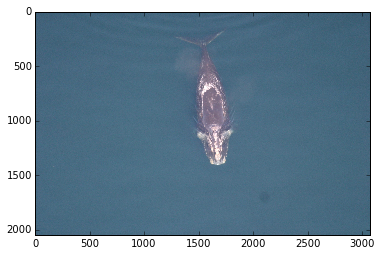

In [65]:
# visualize data
img = imread(data_root+"/train/"+train.Image[0])
pylab.imshow(img)

In [66]:
train.head()

,Image,whaleID,bonnet_tip_x,bonnet_tip_y,blowhead_x,blowhead_y
0,w_7812.jpg,whale_48813,1668.211366,1370.097707,1647.792622,1108.737787
1,w_4598.jpg,whale_09913,1639.625125,1212.873380,1353.762712,1265.962114
2,w_3828.jpg,whale_45062,1118.947159,908.634098,1345.595214,963.764706
3,w_8734.jpg,whale_74162,1690.671984,1223.082752,1682.504487,1069.942173
4,w_3251.jpg,whale_99558,1655.960120,1071.984048,1662.085743,878.005982


In [75]:
scale = 384

class TransIterator(BatchIterator):
    def transform(self, Xb, yb):
        Xb, yb = super(TransIterator, self).transform(Xb, yb)
        
        Xb_aug = []
        Mask = np.zeros((Xb.shape[0], 2, 320, 320), dtype = 'float32')

        # loop for append image and mask
        for n, i in enumerate(Xb):
            # read image
            if yb is None:
                img=imread((data_root+"/test/" + i))
            else:
                img=imread((data_root+"/train/" + i))
                
            # ops on this image
            img = imresize(img, (img.shape[0]*scale/img.shape[1], scale))
            temp = (scale - img.shape[0])//2
            img = np.pad(img, [(temp, temp), (0, 0), (0, 0)], mode='constant')
            img = img/255. - 0.5
            img = imresize(img, (320, 320))
            
            Xb_aug.append(img.astype('float32'))
            
            # masking ops
            if yb is None:
                pass
            else:
                mask = np.zeros(img.shape[:2])
                
                x1 = int(yb[n, 0])
                y1 = int(yb[n, 1])
                try:
                    mask[y1, x1] = 1
                except IndexError:
                    pass

                Mask[n, 0] = mask

                mask = np.zeros(img.shape[:2])
                x1 = int(yb[n, 2])
                y1 = int(yb[n, 3])
                try:
                    mask[y1, x1] = 1
                except IndexError:
                    pass


                Mask[n, 1] = mask

        Xb_aug = np.stack(Xb_aug)

        Xb_aug = np.rollaxis(Xb_aug, 3, 1)
        
        # put mask
        if yb is None:
            yb_aug = yb
        else:
            yb_aug = Mask

            
        print Xb_aug.shape, Xb_aug.max(), yb_aug.shape, yb_aug.max()
        return Xb_aug, yb_aug

In [76]:
from lasagne.layers import InputLayer
from lasagne.layers.dnn import Conv2DDNNLayer as Conv
from lasagne.layers.dnn import Pool2DDNNLayer as Pool
from lasagne.layers import Upscale2DLayer
from lasagne.layers import ConcatLayer
from lasagne.layers import ReshapeLayer
from lasagne.layers import NonlinearityLayer

from lasagne.nonlinearities import softmax

net = {}
l = InputLayer((None, 3, 320, 320))
net['input'] = l

l = Conv(l, 16, 3, pad='same')
net['T4'] = l

l = Conv(Pool(l, 2), 32, 3, pad='same')
net['T3'] = l

l = Conv(Pool(l, 2), 48, 3, pad='same')
net['T2'] = l

l = Conv(Pool(l, 2), 48, 3, pad='same')
net['T1'] = l

l = Conv(Conv(net['T1'], 48, 3, pad='same'), 48, 3, pad='same')
l = Upscale2DLayer(l, 2)
net['M1'] = l

l = ConcatLayer((net['T2'], net['M1']))
l = Conv(Conv(l, 48, 3, pad='same'), 32, 3, pad='same')
l = Upscale2DLayer(l, 2)
net['M2'] = l

l = ConcatLayer((net['T3'], net['M2']))
l = Conv(Conv(l, 32, 3, pad='same'), 16, 3, pad='same')
l = Upscale2DLayer(l, 2)
net['M3'] = l

l = ConcatLayer((net['T4'], net['M3']))
l = Conv(Conv(l, 16, 3, pad='same'), 2, 3, pad='same', nonlinearity=None)

l = ReshapeLayer(l, (-1, 320*320))
l = NonlinearityLayer(l, softmax)
l = ReshapeLayer(l, (-1, 2, 320, 320))
net['M4'] = l

In [77]:
def custom_loss(pred, target):
    loss = objectives.binary_crossentropy(pred.reshape((-1, 320*320)),
                                              target.reshape((-1, 320*320))
                                             )
    return T.mean(loss)
    

# create architecture
net=NeuralNet(
    l,
    
    batch_iterator_train = TransIterator(batch_size = 24),
    batch_iterator_test = TransIterator(batch_size = 10),
    
    objective_loss_function = custom_loss,
    update=updates.adam,
    
    regression=True,
    max_epochs=1,
    verbose=1,
    )

In [78]:
# fit
net.fit(train.Image.values, train.ix[:, 2:].values);

# Neural Network with 164690 learnable parameters

## Layer information

  #    name  size
---  ------  ----------
  0          3x320x320
             16x320x320
             16x160x160
             32x160x160
             32x80x80
             48x80x80
             48x40x40
             48x40x40
             48x40x40
             48x40x40
             48x80x80
             96x80x80
             48x80x80
             32x80x80
             32x160x160
             64x160x160
             32x160x160
             16x160x160
             16x320x320
             32x320x320
             16x320x320
             2x320x320
             102400
             102400
             2x320x320

(24, 3, 320, 320) 255.0 (24, 2, 320, 320) 0.0


TypeError: ('Bad input argument to theano function with name "/home/cuda/anaconda2/lib/python2.7/site-packages/nolearn/lasagne/base.py:484"  at index 1(0-based)', 'Wrong number of dimensions: expected 2, got 4 with shape (24, 2, 320, 320).')